### One-class Classification

This notebook is used to evaluate a set of classificaiton methods, with a selected set of features. We will essentially be building 16 classifiers - one for each user - and we will plot each user in a ROC space according to his True Positive and False Positive rates. In addition to this, we will also evaluate the models with AUC and make a plot where all users and their scores are pictured.

The notebook is designed to make it easy to select a feature set and run the algorithms with it. The parameters for each model are loaded as they have been specified in previous stage from:

    '/data/Main collection - results/'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import display, clear_output
from time import time

# Pretty display for notebooks
%matplotlib inline

random_state = 0

rows_each = 60

# specify the place from where we will use the data
source_path_features_rel = 'data/Main collection - features/'

# specify the target path for the two feature selections
source_path_parameters_rel = 'data/Main collection - results/parameters/'

# find the file names in the directory
feature_files = os.listdir(source_path_features_rel)

# remove the readme, and the Giorgos files
feature_files.remove('README.md')
feature_files.remove('Giorgos Mon 19.csv')
feature_files.remove('Giorgos Wed 21.csv')
feature_files.remove('Giorgos Fri 23.csv')
feature_files.remove('Giorgos Mon 26.csv')
feature_files.remove('best ratios by multiclass RF')

# get the user names out of the feature files
user_names = [name[:-4] for name in feature_files]

print("The number of files in the directory is {}.".format(len(feature_files)))

The number of files in the directory is 16.


In [2]:
# DEBUGGING OPTIONS
np.set_printoptions(threshold=800)
pd.set_option('display.max_rows', 8)
pd.set_option('display.max_columns', 8)

### Load participant data into a single dataframe

In order to do the one class classification we will load all the data into a single dataframe with classes from 1 until 16, and then we will create a new column that will serve as a temporary class column. The temporary column will identify the class we are creating the model for as 1 and all other classes as 0.

In addition to that, because we want to be building the classifier for 60 samples each time, and the feature files sometimes contain more than 60 locks, we will be picking randomly 60 of them.

In [3]:
# initialize the two data frames
X = pd.DataFrame()

for i, file in enumerate(feature_files):
    
    # read each features file into a df
    df = pd.read_csv(source_path_features_rel+file)
    
    # select a sample of 60 values (without replacement)
    df = df.sample(n=rows_each, random_state=random_state, axis=0)
    
    # sort the sampled dataframe by index 
    df.index = range(df.shape[0])
    
    # add the data to the bigger dataframe
    X = pd.concat([X, df.loc[:, :]], ignore_index=True)
    
print("The dataframe that holds the data is as follows:")
display(X)

The dataframe that holds the data is as follows:


,AB_mil,AB_xyz,AB|AC_mil,AB|AC_xyz,...,zSpeed_range,zSpeed_skew,zSpeed_std,zSpeed_var
0,434.0,258.930923,0.418919,0.655369,...,1.081136,-0.149765,0.184878,0.034180
1,502.0,297.418459,0.548035,0.629426,...,2.088235,1.069284,0.282818,0.079986
2,529.0,339.767000,0.549325,0.757873,...,1.235294,0.071162,0.249953,0.062477
3,503.0,301.571361,0.558269,0.689733,...,2.217469,1.207258,0.290968,0.084663
...,...,...,...,...,...,...,...,...,...
956,445.0,158.355584,0.654412,0.820856,...,0.558824,0.489388,0.124969,0.015617
957,436.0,138.876355,0.586022,0.597251,...,0.491597,0.393809,0.109206,0.011926
958,495.0,183.983717,0.651316,0.818607,...,0.897829,-0.483202,0.137261,0.018841
959,477.0,175.668280,0.671831,0.857197,...,0.421429,0.742492,0.105224,0.011072


***

### Feature Selections

In order to select features we will make different groups of features out of the above file with the 916 columns. The groupings refer to the category of feature these features belong to. For example some features are rations, some distances, some simply come from the distributions of the sampled points during the drawing in the x, y or z axis.

After making the groupings, a selected group of features is defined, with which the classifiers are run. This is a **hyper-parameter** that needs to be adjusted in different runs of the notebook.

In [4]:
def loadRatioFeatureIds(file_name, n=30):
    """ Loads the file with features. """
    df = pd.read_csv('data/Main collection - features/best ratios by multiclass RF/' + file_name)
    return df.loc[:n-1, 'feature id']

In [5]:
def findMagnitudes(f1, f2):
    """ Selects the features for both f1 and f2 lists that start with mag. """
    ff = [f for f in f1 if f[:3]=='mag']
    ff.extend([f for f in f2 if f[:3]=='mag'])
    return ff

In [6]:
# get all the features
all_features = X.columns.values.tolist()

# find all positional features
pos_features = [f for f in all_features if f[1:4]=='Pos' and f[4]!='I']

# find all position intervals
posInc_features = [f for f in all_features if f[1:7]=='PosInc' or f[3:9]=='PosInc']

# find all speed intervals
speed_features = [f for f in all_features if f[1:6]=='Speed' or f[3:8]=='Speed']

# find all x axis features
x_features_pos_posInc_speed = [f for f in pos_features if f[0]=='x'] + \
                                [f for f in posInc_features if f[0]=='x'] + \
                                [f for f in speed_features if f[0]=='x']

# find all y axis features
y_features_pos_posInc_speed = [f for f in pos_features if f[0]=='y'] + \
                                [f for f in posInc_features if f[0]=='y'] + \
                                [f for f in speed_features if f[0]=='y']

# find all z axis features
z_features_pos_posInc_speed = [f for f in pos_features if f[0]=='z'] + \
                                [f for f in posInc_features if f[0]=='z'] + \
                                [f for f in speed_features if f[0]=='z']

# find all magnitude features
magnitude_features = findMagnitudes(posInc_features, speed_features)

# combine best overall features
best_overall_features = x_features_pos_posInc_speed + y_features_pos_posInc_speed

# combine all overall features
all_overall_features = pos_features + posInc_features + speed_features

## Distances next ##

# find all euclidean distances
euc_dist_features = [f for f in all_features if f[2]=='_' and f[-3:]=='xyz']

# find all temporal distances
mil_dist_features = [f for f in all_features if f[2]=='_' and f[-3:]=='mil']

# combine euc and mil distances
all_distances = euc_dist_features + mil_dist_features

## Ratios next ##

# find the selected euclidean ratios
euc_all_ratio_features = [f for f in all_features if f[2]=='|' and f[-3:]=='xyz']

# find the selected temporal ratios
mil_all_ratio_features = [f for f in all_features if f[2]=='|' and f[-3:]=='mil']

# combine euc and temp ratios
all_ratio_features = euc_all_ratio_features + mil_all_ratio_features

## best ratios ##

# find the selected euclidean ratios
euc_best_ratio_features = loadRatioFeatureIds('Euclidean distance ratios.csv')

# find the selected temporal ratios
mil_best_ratio_features = loadRatioFeatureIds('Temporal distance ratios.csv')

# all best ratio features
all_best_ratio_features = pd.concat([euc_best_ratio_features, 
                                     mil_best_ratio_features], 
                                    ignore_index=True)

## Best all next ##

## best Combinations ## (1)
best_overall_distances = best_overall_features + all_distances
best_overall_ratios = best_overall_features + list(all_best_ratio_features)
best_ratios_distances = list(all_best_ratio_features) + all_distances
best_overall_distances_ratios = best_overall_features + all_distances + list(all_best_ratio_features)

## best Combinations ## (2 - unused)
pos_with_distances = pos_features + all_distances
pos_with_best_ratios = pos_features + list(all_best_ratio_features)
pos_with_distances_with_best_ratios = pos_features + all_distances + list(all_best_ratio_features)

# all features
#all_features

#### Selection of Features set for running the notebook

The next cell a 'hyper-parameter' for the notebook is selected which is the feature set that we will do the testing for. In the cell above several combinations are specified and in trhe next cell one of them needs to be selected manualy. Also a name should be given to the set. A list of names that correspond with the cell above is:

    'positions', 'position intervals', 'speed intervals', 
    'x_pos_posInt_speed', 'y_pos_posInt_speed', 'z_pos_posInt_speed', 'magnitudes',
    'best_overall', 'all_overall',
    'euclidean distances', 'temporal distances', 'all_distances',
    'all euclidean ratios', 'all temporal ratios', 'all ratio features',
    'best euclidean ratios', 'best temporal ratios', 'all best ratios',
    'best overall distances', 'best overall ratios', 'best ratios distances', 
        'best overall dist ratios',
    'pos with distances', 'pos with best ratios', 'pos_distances_best_ratios',
    'all features'

In [7]:
# Feature set selection
selected_feature_set = pos_with_distances_with_best_ratios
# Feature set name selection
feature_set_name = 'pos_distances_best_ratios'

***

### Classifiers

In order to proceed with the classification task, four classifiers will be selected, these are:

1. One-class SVM
2. Isolation Forest

In order to use them, we will use the parameters that we have specified in an earlier tuning stage. The tuned files i can use here are:

    file_name+'one-class SVM.csv'
             +'one-class SVM (AUC) - 7 basic + all.csv'
             +'one-class SVM (AUC) - group 24.csv'
             +'Isolation Forest.csv'
             +'Isolation Forest (AUC) - group 25.csv'

In [8]:
from sklearn import svm
from sklearn.ensemble import IsolationForest

In [9]:
# set the common name all files share
file_name = source_path_parameters_rel+'Optimal Parameters --- '

# load parameters
optimal_params_OCSVM = pd.read_csv(file_name+'one-class SVM (AUC) - group 24.csv', nrows=5, 
                                   index_col=0, squeeze=True)
optimal_params_IF = pd.read_csv(file_name+'Isolation Forest.csv', nrows=4, 
                                index_col=0, squeeze=True)

In [10]:
# initialize the one-class SVM
clf_OCSVM = svm.OneClassSVM(kernel=optimal_params_OCSVM['kernel'], 
                            nu=float(optimal_params_OCSVM['nu']), 
                            degree=float(optimal_params_OCSVM['degree']),
                            gamma=float(optimal_params_OCSVM['gamma']),
                            coef0=float(optimal_params_OCSVM['coef0']))

# initialize the Isolation Forest
clf_IF = IsolationForest(n_estimators=int(optimal_params_IF['n_estimators']), 
                         max_samples=float(optimal_params_IF['max_samples']), 
                         contamination=float(optimal_params_IF['contamination']),
                         max_features=float(optimal_params_IF['max_features']), 
                         bootstrap=False, 
                         n_jobs=-1, 
                         random_state=random_state, 
                         verbose=0)

***

### Classification and Graphs

The product of this section of the notebook should be a few graphs and a log for every participant that contains his name, his AUC scores, and the TP, FP rates. In order to achieve this we first define the graph functions and then we run those after the classification process.

#### Graphs

There will be two kinds of scatterplot graphs that will show users in a ROC space, and one graph that will show the AUCs for all participants (in the next section there will be some convergence graphs also). 

Also, as far as the scatterplot graphs go, one will include the standard deviation that resulted in the FP or TP rate and the other will show all the algorithms together.

In [11]:
from matplotlib.patches import Ellipse

from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [12]:
# style
plt.style.use('bmh')

In [13]:
def plotAUC(clf_name, feature_name, FP_rates, TP_rates, AUC_scores, saving_path=''):
    """ Plots the classifier of each participant in the ROC space as scatterplot """
    
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    # init the figure and the axes object
    fig, ax = plt.subplots(1, 1)
    fig.set_tight_layout(False)

    # adjust the size of the figure
    fig.set_figwidth(8)
    fig.set_figheight(6)

    # plot the curves for each participant
    for i in range(len(AUC_scores)):
        
        fpr = FP_rates[i]
        tpr = TP_rates[i]

        # make the y of the the line that can be used to make the mean ROC line
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

        # plot the curve of the corresponding participant
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                label='ROC participant %d (AUC = %0.2f)' % (i+1, AUC_scores[i+1]))
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', label='Luck', alpha=.8)
    
    # find the mean line
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    if not saving_path:
    
        # calculate EER
        eer = brentq(lambda x : 1. - x - interp1d(mean_fpr, mean_tpr)(x), 0., 1.)
        
        print("\nThe exact EER for the following mean curve is {}.".format(eer))
    
        #thresh = interp1d(mean_fpr, thresholds)(eer)

        ### DEBUGGING FOR EER
#         mean_fnr = 1 - mean_tpr

#         print("The mean fnrs are:\n{}\n".format(mean_fnr))
#         print("The mean fprs are:\n{}\n".format(mean_fpr))

#         print("The difference array is:\n{}\n.".format(np.absolute(mean_fnr - mean_fpr)))

#         EER_tpr = mean_fnr[np.nanargmin(np.absolute((mean_fnr - mean_fpr)))]
#         EER_fpr = mean_fpr[np.nanargmin(np.absolute((mean_fnr - mean_fpr)))]

#         print("The EER given the tpr axis is {}.".format(EER_tpr))
#         print("The EER given the fpr axis is {} (if one of the two should be used, maybe this is better).".format(EER_fpr))

#         print("The mean EER according to the approximation is {}.".format(np.mean([EER_tpr, EER_fpr])))
    
    # find the mean auc score
    mean_auc = auc(mean_fpr, mean_tpr)
    
    # find the std of the auc scores
    std_auc = np.std(AUC_scores)
    
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC curves for all 16 participants of \n{}, on '{}'"
              .format(clf_name, feature_name)) if not saving_path else None
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # save or show
    if saving_path:
        fig.savefig("{}ROC curves of {}, on '{}' for all 16 participants"
                    .format(saving_path, clf_name, feature_name)+'.png', bbox_inches='tight') 
    else:
        plt.show()
        
    # close the image
    plt.close()

In [14]:
def plotROCSpaceWithStd(df, feature_name, algorithm_name, y_low, color='white', saving_path=''):
    """ Plots the classifier of each participant in the ROC space as scatterplot """
    
    # init the figure and the axes object
    fig, ax = plt.subplots(1, 1)
    fig.set_tight_layout(False)

    # adjust the size of the figure
    fig.set_figwidth(6)
    fig.set_figheight(6)
    
    # scale the dataframes
    #df = df*0.01
    
    #['TP_rates_mean', 'TP_rates_std', 'FP_rate']
    
    # plot df1 points
    ax.scatter(df.loc[:, 'FP_rate'], 
               df.loc[:, 'TP_rates_mean'], 
               color=color,
               edgecolors='black', 
               alpha=0.85)
    
    # find the ellipses for df1 that show the std
    ells_df = [Ellipse(xy=(df.loc[i, ['FP_rate']], df.loc[i, ['TP_rates_mean']]), 
                       width=0.02,#df.loc[i, 'FP std cv']*2, 
                       height=df.loc[i, 'TP_rates_std']*2, angle=0) for i in df.index.values]
    
    # plot the stds of the df1 points
    for e in ells_df:
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_alpha(0.1)
        e.set_facecolor(color)

    # set text axes
    ax.set_title("ROC space of {} on '{}'"
                 .format(algorithm_name, feature_name)) if not saving_path else None
    ax.set_xlabel('False Positive rate')
    ax.set_ylabel('True Positive rate')
    # set limits in axis
    ax.set_xlim([0, 1])
    ax.set_ylim([y_low, 1])
    
    # save or show
    if saving_path:
        fig.savefig("{}ROC space of {} on '{}'"
                    .format(saving_path, algorithm_name, feature_name)+'.png', bbox_inches='tight') 
    else:
        plt.show()
        
    # close the image
    plt.close()

In [15]:
def plotROCSpaceAllResults(feature_name, y_low, *args, saving_path=''):
    """ Plots the classifier of each participant in the ROC space as scatterplot """
    
    # init the figure and the axes object
    fig, ax = plt.subplots(1, 1)
    fig.set_tight_layout(False)

    # adjust the size of the figure
    fig.set_figwidth(6)
    fig.set_figheight(6)
    
    names = []
    
    for df, alg_name, color in args:
        
        # scale the dataframes
        #df = df*0.01
        
        names.append(alg_name)

        # plot df1 points
        ax.scatter(df.loc[:, 'FP_rate'], 
                   df.loc[:, 'TP_rates_mean'], 
                   color=color,
                   edgecolors='black', 
                   alpha=0.85)
    
    # set text axes
    ax.set_title("ROC space of all classifiers, on '{}'"
                 .format(feature_name)) if not saving_path else None
    ax.set_xlabel('False Positive rate')
    ax.set_ylabel('True Positive rate')
    # set limits in axis
    ax.set_xlim([0, 1])
    ax.set_ylim([y_low, 1])
    
    # set the legend
    ax.legend(names, shadow=True)
    
    # save or show
    if saving_path:
        fig.savefig("{}ROC space of all classifiers, on '{}'"
                    .format(saving_path, feature_name)+'.png', bbox_inches='tight') 
    else:
        plt.show()
        
    # close the image
    plt.close()

#### Classification

In this section we will use the aforementioned algorithms, a scaling technique and 5 fold cross validation to get True Positive and False Positive rates.

In [16]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from scipy import interp
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [17]:
pd.set_option('display.max_rows', 80)
pd.set_option('display.max_columns', 80)

In [18]:
def findFalseNegatives(pred):
    """ Finds the False Negatives in a prediction of only positive samples. """
    # get the unique predicted labels and their counts in a dictionary
    unique_counts = dict(zip(*np.unique(pred, return_counts=True)))
    # find the correct predictions
    num_correct_predictions = unique_counts[-1] if -1 in unique_counts else 0
    #return the ratio
    return num_correct_predictions / sum(unique_counts.values())

# def findFalseNegatives_two(pred):
#     """ Finds the False Negatives in a prediction of only positive samples. """
#     return pred.count(-1) / len(pred)

In [19]:
def findFalsePositives(pred):
    """ Finds the False Positives in a prediction of only negative samples. """
    # get the unique predicted labels and their counts in a dictionary
    unique_counts = dict(zip(*np.unique(pred, return_counts=True)))
    # find the correct predictions
    num_correct_predictions = unique_counts[1] if 1 in unique_counts else 0
    #return the ratio
    return num_correct_predictions / sum(unique_counts.values())

# def findFalsePositives_two(pred):
#     """ Finds the (False) Positives in a prediction of only Negative samples. """
#     return pred.count(1) / len(pred)

In [20]:
def createResultsDataStructure(n_folds, n_rows):
    """ Creates a data structure that will be used for the classification task. The data structure 
    should contain a row for every user and columns that will be usefull later on. These columns
    should contain: user_id, user's name, cross-validated rates of FNs and TPs, the mean and stds 
    of those scores, the FP and TN rates. """
    
    # make the index and the user id column
    df_index = list(range(1, n_rows+1))
    
    identifiers = ['user_id', 'user_name']
    auc_stuff = ['auc_score (cv-d)', 'auc_score_std']
    means_stds_FNs_FPs = ['FN_rates_mean', 'FN_rates_std', 'FP_rates_mean',  'FP_rates_std']
    cv_FNs = ['FN_cv'+str(i+1) for i in range(n_folds)]
    cv_FPs = ['FP_cv'+str(i+1) for i in range(n_folds)]
    
    # make the columns list
    df_columns = identifiers + auc_stuff + means_stds_FNs_FPs + cv_FNs + cv_FPs
    
    df = pd.DataFrame(index=df_index, columns=df_columns)
    
    df.loc[:, 'user_id'] = df_index
    
    return df, cv_FNs, cv_FPs

In [21]:
def classification(X_all_users_raw, user_names, clf, clf_name,
                   scaler, random_state, saving_path, feature_name,
                   num_participants=16, locks_per_participant=60, 
                   n_folds=5, verbose=False):
    """ Loops over 16 participands and gets a classiifcation score. """
    
    start = time()
    
    # initialize the data structure that will be returned
    df_results, cv_FN_cols, cv_FP_cols = createResultsDataStructure(n_folds, num_participants)
    
    FPRs = []
    TPRs = []
    
    mean_FPR = np.linspace(0, 1, 100)
        
    for i in range(num_participants):
        
        clear_output()
        print("-- tracker: Working on participant {}.".format(i+1))
        
        user_id = i+1
        
        #print("i is {}".format(i))
        
        # find the starting index of the original dataframe
        idx = i*locks_per_participant
        
        # find the mask for positive values to slice the dataset
        positive_mask = X_all_users_raw.index.isin(range(idx, idx+locks_per_participant))
        
        # find the lines that correspond to this participant
        X_pos = X_all_users_raw.loc[positive_mask, :]
                
        # find the lines that correspond to all other participants
        X_neg = X_all_users_raw.loc[~positive_mask, :]
        
        # reset the index of the features dataframe
        X_pos.index = range(X_pos.shape[0])
                        
        # reset the index of the features dataframe
        X_neg.index = range(X_neg.shape[0])
                        
        # initialize a cross validation object
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
        
        # FNs -------------------------------------------------------------------------
        
        FN_rates_cv = []
        FP_rates_cv = []
        TPRs_cv = []
        auc_rates_cv = []
        
        # find 
        for train, test in kf.split(X_pos):
            
            # use scaler
            scaler.fit(X_pos.loc[train, :])                                 # fit the scaler to train positive samples
            X_pos_transformed_train = scaler.transform(X_pos.loc[train, :]) # transform train positive samples
            X_pos_transformed_test = scaler.transform(X_pos.loc[test, :])   # transform test positive samples
            X_neg_transformed_test = scaler.transform(X_neg)                # transform all negative samples
            
            # fit the classifier
            clf.fit(X_pos_transformed_train)
            
            # make predictions on Positive data
            prediction_pos = clf.predict(X_pos_transformed_test)
            
            # find the false negatives of the split and save to the array
            FN_rates_cv.append(findFalseNegatives(prediction_pos))
            
            # make predictions on Positive data
            prediction_neg = clf.predict(X_neg_transformed_test)
            
            # find the false negatives of the split and save to the array
            FP_rates_cv.append(findFalsePositives(prediction_neg))
            
            # --- auc ---
            
            # make prediction with decision function on Positive data
            prediction_pos_DF = clf.decision_function(X_pos_transformed_test)

            # make prediction with decision function on Negative data
            prediction_neg_DF = clf.decision_function(X_neg_transformed_test)
            
            y_true = [1 for _ in range(prediction_pos_DF.shape[0])] + [0 for _ in range(prediction_neg_DF.shape[0])]
            y_scores = [s for s in prediction_pos_DF] + [s for s in prediction_neg_DF]
        
            # find values for the ROC curve
            fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
            
            # interpolate the linear space of mean_FPR to the fpr, tpr coordinates
            TPRs_cv.append(interp(mean_FPR, fpr, tpr))
            TPRs_cv[-1][0] = 0.0
            
            # add the auc rate to a list (will not be used for mean curve AUC tho - only for std)
            auc_rates_cv.append(auc(fpr, tpr))
            
        # get the true positives as opposite to False Negatives
        TP_rates_cv = [1-val for val in FN_rates_cv]
        TN_rates_cv = [1-val for val in FP_rates_cv]
        
        # find the mean curve
        mean_tpr = np.mean(TPRs_cv, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_FPR, mean_tpr)
        std_auc = np.std(auc_rates_cv) 
                
        TPRs.append(mean_tpr)
        FPRs.append(mean_FPR)
        
        # make the entry into the results dataframe for the given user
#         df_results.loc[user_id, 'user_name'] = user_names[i]
        df_results.loc[user_id, 'auc_score (cv-d)'] = mean_auc
        df_results.loc[user_id, 'auc_score_std'] = std_auc
        # cross-validation results
        df_results.loc[user_id, cv_FN_cols] = FN_rates_cv
        df_results.loc[user_id, cv_FP_cols] = FP_rates_cv
        df_results.loc[user_id, ['FN_rates_mean', 'FN_rates_std']] = np.mean(FN_rates_cv), np.std(FN_rates_cv)
        df_results.loc[user_id, ['FP_rates_mean', 'FP_rates_std']] = np.mean(FP_rates_cv), np.std(FP_rates_cv)
        
    clear_output()
    print("Found the scores of {} participants in {:.2f} minutes"
          .format(num_participants, (time()-start)/60))
    
    return df_results, FPRs, TPRs

In [22]:
# initialize the scalar
scaler = MinMaxScaler()

# path to drop logs
logs_path = 'data/Main collection - results/logs/'

# path to save images
img_save_path = 'data/Main collection - results/images/'

#
y_low_clip = 0.6

# initialize the dataframe with the fewer features that will be used here
X_selected_features = X.loc[:, selected_feature_set]

##### Run for one-class SVM:

Found the scores of 16 participants in 0.03 minutes


,user_id,user_name,auc_score (cv-d),auc_score_std,FN_rates_mean,FN_rates_std,FP_rates_mean,FP_rates_std,FN_cv1,FN_cv2,FN_cv3,FN_cv4,FN_cv5,FP_cv1,FP_cv2,FP_cv3,FP_cv4,FP_cv5
1,1,NaN,0.992761,0.00214095,0.7,0.15456,0,0,0.583333,0.833333,0.666667,0.5,0.916667,0,0,0,0,0
2,2,NaN,0.994276,0.00173165,0.616667,0.0849837,0,0,0.75,0.5,0.583333,0.666667,0.583333,0,0,0,0,0
3,3,NaN,0.976768,0.03166,0.533333,0.266667,0,0,0.0833333,0.416667,0.75,0.583333,0.833333,0,0,0,0,0
4,4,NaN,0.994949,0.000336406,0.6,0.169967,0,0,0.75,0.833333,0.416667,0.583333,0.416667,0,0,0,0,0
5,5,NaN,0.994444,0.000722934,0.65,0.110554,0,0,0.833333,0.666667,0.583333,0.5,0.666667,0,0,0,0,0
6,6,NaN,0.985017,0.00786904,0.633333,0.124722,0,0,0.416667,0.75,0.583333,0.666667,0.75,0,0,0,0,0
7,7,NaN,0.994949,0.000372218,0.65,0.062361,0,0,0.75,0.666667,0.583333,0.666667,0.583333,0,0,0,0,0
8,8,NaN,0.992929,0.00079306,0.666667,0.149071,0,0,0.75,0.833333,0.583333,0.75,0.416667,0,0,0,0,0
9,9,NaN,0.994613,0.000455119,0.583333,0.0912871,0,0,0.75,0.583333,0.5,0.5,0.583333,0,0,0,0,0
10,10,NaN,0.992929,0.00436802,0.6,0.143372,0,0,0.583333,0.833333,0.666667,0.5,0.416667,0,0,0,0,0



The exact EER for the following mean curve is 0.040540540540568645.


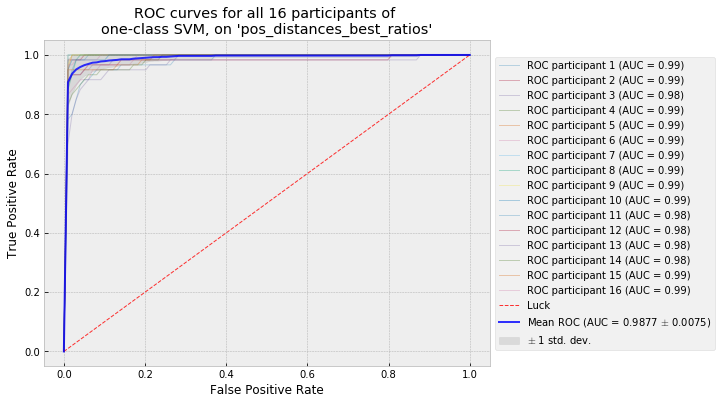

In [23]:
clf_name_OCSVM = 'one-class SVM'
clf_color_OCSVM = 'r'

# do the classification with the selected data
df_OCSVM_logs, FP_rates_SVM, TP_rates_SVM = classification(X_selected_features, user_names, 
                                                   clf_OCSVM, clf_name_OCSVM, scaler, random_state,
                                                   img_save_path, feature_set_name)

display(df_OCSVM_logs)

# drop the dataframe into a csv
df_OCSVM_logs.to_csv(logs_path + "logs of {} on '{}' features.csv"
                     .format(clf_name_OCSVM, feature_set_name), index=False)

# show the AUC plot of participants for OCSVM
plotAUC(clf_name_OCSVM, feature_set_name, FP_rates_SVM, TP_rates_SVM, 
        df_OCSVM_logs['auc_score (cv-d)'], saving_path='')

# save the AUC plot of participants for OCSVM
plotAUC(clf_name_OCSVM, feature_set_name, FP_rates_SVM, TP_rates_SVM, 
        df_OCSVM_logs['auc_score (cv-d)'], saving_path=img_save_path)

# # plot participants for SVM with the stds for the results
# plotROCSpaceWithStd(df_OCSVM_logs.loc[:, ['TP_rates_mean', 'TP_rates_std', 'FP_rate']], 
#                     feature_set_name, clf_name_OCSVM, y_low_clip, color=clf_color_OCSVM)

# # save the plot of participants for SVM with the stds for the results
# plotROCSpaceWithStd(df_OCSVM_logs.loc[:, ['TP_rates_mean', 'TP_rates_std', 'FP_rate']], 
#                     feature_set_name, clf_name_OCSVM, y_low_clip,
#                     color=clf_color_OCSVM, saving_path=img_save_path)

##### Run for Isolation Forest:

Found the scores of 16 participants in 4.63 minutes


,user_id,user_name,auc_score (cv-d),auc_score_std,FN_rates_mean,FN_rates_std,FP_rates_mean,FP_rates_std,FN_cv1,FN_cv2,FN_cv3,FN_cv4,FN_cv5,FP_cv1,FP_cv2,FP_cv3,FP_cv4,FP_cv5
1,1,NaN,0.986532,0.00437743,0.183333,0.062361,0.00977778,0.00559541,0.166667,0.166667,0.25,0.0833333,0.25,0.00222222,0.0188889,0.00666667,0.00888889,0.0122222
2,2,NaN,0.969697,0.0228229,0.166667,0.0745356,0.0368889,0.00563937,0.166667,0.0833333,0.25,0.25,0.0833333,0.0344444,0.0322222,0.0333333,0.0366667,0.0477778
3,3,NaN,0.964646,0.0333408,0.216667,0.201384,0.0262222,0.0140651,0,0.0833333,0.25,0.166667,0.583333,0.0366667,0.0466667,0.0233333,0.0177778,0.00666667
4,4,NaN,0.991751,0.00131807,0.2,0.0849837,0.00955556,0.00150718,0.0833333,0.333333,0.25,0.166667,0.166667,0.01,0.00777778,0.0111111,0.00777778,0.0111111
5,5,NaN,0.991414,0.00146753,0.183333,0.062361,0.00733333,0.00113312,0.25,0.25,0.166667,0.0833333,0.166667,0.00777778,0.00555556,0.00666667,0.00888889,0.00777778
6,6,NaN,0.952357,0.0398092,0.183333,0.0971825,0.0177778,0.00831479,0,0.25,0.25,0.166667,0.25,0.02,0.00888889,0.02,0.00888889,0.0311111
7,7,NaN,0.987205,0.00423034,0.2,0.15456,0.0115556,0.00239341,0.5,0.166667,0.0833333,0.0833333,0.166667,0.01,0.0144444,0.0144444,0.00888889,0.01
8,8,NaN,0.949158,0.0201505,0.216667,0.0849837,0.0828889,0.0241559,0.333333,0.166667,0.25,0.25,0.0833333,0.0444444,0.102222,0.113333,0.0833333,0.0711111
9,9,NaN,0.993098,0.00196209,0.15,0.0971825,0.00355556,0.000831479,0.0833333,0.25,0.25,0.166667,0,0.00444444,0.00222222,0.00333333,0.00333333,0.00444444
10,10,NaN,0.984343,0.0110395,0.183333,0.143372,0.0106667,0.00401233,0.166667,0.0833333,0.25,0.416667,0,0.0166667,0.0122222,0.00444444,0.00888889,0.0111111



The exact EER for the following mean curve is 0.07699154428126394.


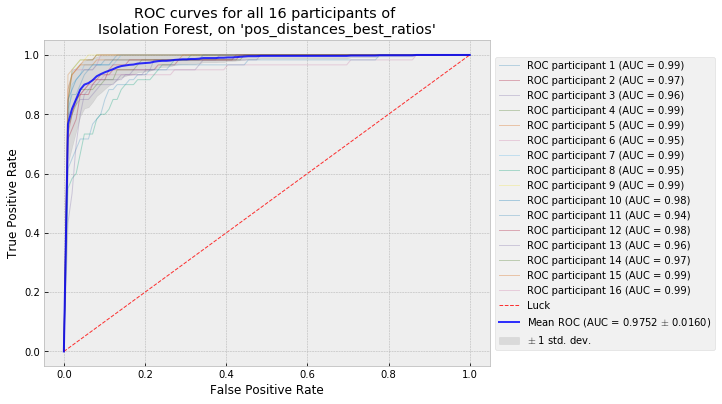

In [24]:
clf_name_IF = 'Isolation Forest'
clf_color_IF = 'b'

# do the classification with the selected data
df_IF_logs, FP_rates_IF, TP_rates_IF = classification(X_selected_features, user_names, 
                                                      clf_IF, clf_name_IF, scaler, 
                                                      random_state,
                                                      img_save_path, feature_set_name)

display(df_IF_logs)

# drop the dataframe into a csv
df_IF_logs.to_csv(logs_path + "logs of {} on '{}' features.csv"
                  .format(clf_name_IF, feature_set_name), index=False)

# show the AUC plot of participants for OCSVM
plotAUC(clf_name_IF, feature_set_name, FP_rates_IF, TP_rates_IF, 
        df_IF_logs['auc_score (cv-d)'], saving_path='')

# save the AUC plot of participants for OCSVM
plotAUC(clf_name_IF, feature_set_name, FP_rates_IF, TP_rates_IF, 
        df_IF_logs['auc_score (cv-d)'], saving_path=img_save_path)

# # plot participants for SVM with the stds for the results
# plotROCSpaceWithStd(df_IF_logs.loc[:, ['TP_rates_mean', 'TP_rates_std', 'FP_rate']], 
#                     feature_set_name, clf_name_IF, y_low_clip, color=clf_color_IF)

# # save the plot of participants for SVM with the stds for the results
# plotROCSpaceWithStd(df_IF_logs.loc[:, ['TP_rates_mean', 'TP_rates_std', 'FP_rate']], 
#                     feature_set_name, clf_name_IF, y_low_clip, 
#                     color=clf_color_IF, saving_path=img_save_path)

##### ROC Space plot for all algorithms together:

In [25]:
# # show a plot
# plotROCSpaceAllResults(feature_set_name, y_low_clip,
#                        [df_OCSVM_logs.loc[:, ['TP_rates_mean', 'FP_rate']], 
#                         clf_name_OCSVM, clf_color_OCSVM], 
#                        [df_IF_logs.loc[:, ['TP_rates_mean', 'FP_rate']], 
#                         clf_name_IF, clf_color_IF])

# # save a plot of the results of al algorithms together without the std
# plotROCSpaceAllResults(feature_set_name, y_low_clip,
#                        [df_OCSVM_logs.loc[:, ['TP_rates_mean', 'FP_rate']], 
#                         clf_name_OCSVM, clf_color_OCSVM], 
#                        [df_IF_logs.loc[:, ['TP_rates_mean', 'FP_rate']], 
#                         clf_name_IF, clf_color_IF], saving_path=img_save_path)

***

### Corvengence rate for individual users

In this section we will be looking at the conversion rates of the AUCs of all the users that participated in the experiment. We will split the users into two groups according to their AUC performances in the previous experiment. These groups will be:

    the best performing 4 and,
    the worst performing 4

In [26]:
# find the four worse performing users in the SVM case
worst_performing_user_ids_OCSVM = df_OCSVM_logs.loc[:, 'auc_score (cv-d)'].sort_values().head(4).index.values

print("The {} worst performing users are: {}"
      .format(len(worst_performing_user_ids_OCSVM), worst_performing_user_ids_OCSVM))

The 4 worst performing users are: [13 11  3 12]


In [27]:
# find the four worse performing users in the SVM case
best_performing_user_ids_OCSVM = df_OCSVM_logs.loc[:, 'auc_score (cv-d)'].sort_values().tail(4).index.values

# reverse to get the best one in front
best_performing_user_ids_OCSVM = list(reversed(best_performing_user_ids_OCSVM))

print("The {} best performing users are: {}"
      .format(len(best_performing_user_ids_OCSVM), best_performing_user_ids_OCSVM))

The 4 best performing users are: [7, 4, 9, 5]


In [28]:
# find the four worse performing users in the SVM case
worst_performing_user_ids_IF = df_IF_logs.loc[:, 'auc_score (cv-d)'].sort_values().head(4).index.values

print("The {} worst performing users are: {}"
      .format(len(worst_performing_user_ids_IF), worst_performing_user_ids_IF))

The 4 worst performing users are: [11  8  6 13]


In [29]:
# find the four worse performing users in the SVM case
best_performing_user_ids_IF = df_IF_logs.loc[:, 'auc_score (cv-d)'].sort_values().tail(4).index.values

# reverse to get the best one in front
best_performing_user_ids_IF = list(reversed(best_performing_user_ids_IF))

print("The {} best performing users are: {}"
      .format(len(best_performing_user_ids_IF), best_performing_user_ids_IF))

The 4 best performing users are: [9, 4, 5, 16]


### Make plots for the results

In [30]:
# style
plt.style.use('bmh')

def plotErrorToSampleCounts(x, df_ys, feature_set_name, classifier_name, 
                            num_samples, participant_types, saving_path=''):
    """ Plots a convergence line of a given feature set and classifier. """
    
    # drop the column with the user ids from the data frame
    df_ys = df_ys.drop(['user_id'], axis=1)
    
    # init the figure and the axes object
    fig, ax = plt.subplots(1, 1)
    fig.set_tight_layout(False)

    # adjust the size of the figure
    fig.set_figwidth(6)
    fig.set_figheight(6)
    
    names_legend = []
    
    rolling_color = [0.05, 0.8, 0.05]
            
    for index, row in df_ys.iterrows():
        
        names_legend.append('Participant {}'.format(index))
        
        # plot rows
        ax.plot(x, row, linewidth=1, color=tuple(rolling_color))#, linestyle='dashed'
        
        rolling_color[0] += 0.15
        rolling_color[2] += 0.15
    
    # set text axes
    ax.set_title("Convergence rate of {} on '{}'\nfeatures for the {} {} performing participants"
                 .format(classifier_name, feature_set_name, df_ys.shape[0], participant_types)) if not saving_path else None
    ax.set_xlabel('number of training samples')
    ax.set_ylabel('scores')
    # set limits in axis
    ax.set_xlim([0, num_samples])
    ax.set_ylim([0, 1])
    
    # set the legend
    ax.legend(names_legend, shadow=True)
    
    # save or show
    if saving_path:
        fig.savefig("{}/Error against number of training samples of {} on '{}' features for the {} {} performing participants"
                    .format(saving_path, classifier_name, feature_set_name, df_ys.shape[0], participant_types)+'.png', bbox_inches='tight') 
    else:
        plt.show()
        
    # close the image
    plt.close()

#### AUC convergence rate

The next step is to make functionality that creates a data structure tha decribes the AUC convergence rate for a participant. The functions need to isolate the participant and then get the AUC performance in multiple cases.

In [31]:
def classify(X_train_pos, X_test_pos, X_test_neg, clf, scaler):
    """ Finds the convergence line of a classifier, in different samples. """
    
    # fit the scalar
    scaler.fit(X_train_pos)

    # scale all data before fitting the classifier or making predictions
    X_train_pos_transformed = scaler.transform(X_train_pos)
    X_test_pos_transformed = scaler.transform(X_test_pos)
    X_test_neg_transformed = scaler.transform(X_test_neg)
            
    # fit the classifier
    clf.fit(X_train_pos_transformed)

    # make predictions on Positive data
    prediction_Pos = clf.predict(X_test_pos_transformed)
    prediction_Pos_DF = clf.decision_function(X_test_pos_transformed)
    # make predictions on Negative data
    prediction_Neg = clf.predict(X_test_neg_transformed)
    prediction_Neg_DF = clf.decision_function(X_test_neg_transformed)

    # find the false negatives of the split and save to the array
    FN_rate = findFalseNegatives(prediction_Pos)
    # find the false positives
    FP_rate = findFalsePositives(prediction_Neg)
        
    y_true = [-1 for _ in range(prediction_Neg_DF.shape[0])] + [1 for _ in range(prediction_Pos_DF.shape[0])]
    y_scores = [s for s in prediction_Neg_DF] + [s for s in prediction_Pos_DF]

    #
    auc_score = roc_auc_score(y_true, y_scores)
    
    return FN_rate, FP_rate, auc_score

In [32]:
def convergence_rate_many_users(X_all_users_raw, user_ids, clf,
                   scaler, random_state, samples, repetitions, num_test_samples,
                   num_participants=16, locks_per_participant=60, 
                   n_folds=5, verbose=False):
    """  """
    
    df_AUCs = pd.DataFrame(columns=['user_id']+samples, 
                           index=user_ids)
    
    df_AUCs.loc[:, 'user_id'] = user_ids
    
    for counter_par, par_id in enumerate(user_ids):
        
        # find the starting index of the original dataframe
        idx = (par_id-1)*locks_per_participant
        
        # find the mask for positive values to slice the dataset
        positive_mask = X_all_users_raw.index.isin(range(idx, idx+locks_per_participant))
        
        # find the lines that correspond to this participant
        X_mix_pos = X_all_users_raw.loc[positive_mask, :]
                
        # find the lines that correspond to all other participants
        X_test_neg = X_all_users_raw.loc[~positive_mask, :]
        
        # reset the index of the features dataframe
        X_mix_pos.index = range(X_mix_pos.shape[0])
                        
        # reset the index of the features dataframe
        X_test_neg.index = range(X_test_neg.shape[0])
        
        for s in samples:
            
            clear_output()
            print("-- tracker: Working on training sample size of {} (participant {}/4)".format(s, counter_par+1))
        
            AUCs = []

            for rep in range(repetitions):

                state = rep

                # select a sample of 60 values (without replacement)
                X_train_pos_sampled = X_mix_pos.sample(n=s, random_state=state, axis=0)

                # find the sampled indices
                train_indices = X_mix_pos.index.isin(X_train_pos_sampled.index.values)

                # sample again excluding the already sampled indices
                X_test_pos_sampled = X_mix_pos.loc[~train_indices, :].sample(n=num_test_samples, 
                                                                             random_state=state, 
                                                                             axis=0)

                # sort the sampled dataframe by index 
                X_train_pos_sampled.index = range(X_train_pos_sampled.shape[0])

                # sort the sampled dataframe by index 
                X_test_pos_sampled.index = range(X_test_pos_sampled.shape[0])

                # get a score for 
                FN, FP, AUC = classify(X_train_pos_sampled, X_test_pos_sampled, X_test_neg, clf, scaler)

                #FNs.append(FN)   # add it to the FNs for all repetitions
                #FPs.append(FP)   # add it to the FPs for all repetitions
                AUCs.append(AUC) # add it to the AUCs for all repetitions

#             scores_FN.append(np.mean(FNs))   # add it to the FN scores that corresponds to samples list
#             scores_FP.append(np.mean(FPs))   # add it to the FP scores that corresponds to samples list
#             scores_AUC.append(np.mean(AUCs)) # add it to the AUC scores that corresponds to samples list
            
            df_AUCs.loc[par_id, s] = np.mean(AUCs)
            
    return df_AUCs
        

##### Set parameters:

In [33]:
# set the max number of samples that will be used for train
num_pos_train_convergence = 40

# set the FIX number of samples that will be used for test
num_pos_test_convergence = 60 - num_pos_train_convergence

# initialize the sumber of samples
samples = list(range(1, 41))

# select a repetitions parameter for the time each point is calculated
reps = 20

##### Find for the four worst users (OCSVM case):

In [34]:
df_AUC_scores_worst_4_OCSVM = convergence_rate_many_users(X_selected_features, 
                                            worst_performing_user_ids_OCSVM, 
                                            clf_OCSVM, scaler, random_state, 
                                            samples, reps, 
                                            num_pos_test_convergence)

-- tracker: Working on training sample size of 40 (participant 4/4)


In [35]:
display(df_AUC_scores_worst_4_OCSVM)

# drop the dataframe into a csv
df_AUC_scores_worst_4_OCSVM.to_csv(logs_path + "worst 4 users AUC convergence scores of {} on '{}' features.csv"
                                                .format(clf_name_OCSVM, feature_set_name), index=False)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
13,13,0.5,0.5,0.726506,0.917296,0.945614,0.951336,0.957944,0.956196,0.963,0.966275,0.963614,0.971811,0.972792,0.972644,0.975575,0.975386,0.979044,0.976219,0.976533,0.971681,0.971992,0.973511,0.9706,0.970667,0.969833,0.969689,0.968947,0.973214,0.973656,0.974358,0.972092,0.976153,0.974247,0.974047,0.970669,0.970467,0.967408,0.968886,0.970806,0.971458
11,11,0.5,0.5,0.737863,0.871281,0.907768,0.936793,0.939339,0.944847,0.95975,0.956969,0.959153,0.958744,0.961622,0.965439,0.966806,0.973256,0.968722,0.972075,0.972247,0.972203,0.97585,0.976931,0.977175,0.982208,0.982492,0.982058,0.981433,0.983814,0.984381,0.985567,0.985517,0.986817,0.984275,0.984125,0.985133,0.985531,0.985111,0.986014,0.985814,0.984883
3,3,0.5,0.5,0.677015,0.890788,0.946589,0.962004,0.969485,0.966939,0.973043,0.972657,0.968803,0.978261,0.980061,0.973322,0.975019,0.977658,0.972994,0.977717,0.974708,0.974469,0.972281,0.976628,0.973086,0.974578,0.97565,0.981583,0.981975,0.972314,0.973939,0.983142,0.977339,0.978183,0.977214,0.977956,0.979786,0.975883,0.976164,0.976281,0.975717,0.975653
12,12,0.5,0.5,0.75895,0.916251,0.959156,0.970735,0.969474,0.970676,0.978058,0.975875,0.971336,0.976972,0.976247,0.978353,0.97805,0.977531,0.981064,0.984214,0.985311,0.980025,0.979564,0.982339,0.983725,0.983631,0.976944,0.973922,0.973667,0.979964,0.979161,0.980061,0.981953,0.985636,0.981506,0.982428,0.982431,0.982278,0.978458,0.978406,0.978322,0.976483


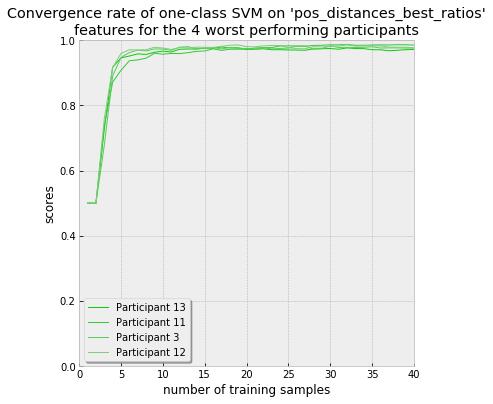

In [36]:
plotErrorToSampleCounts(samples, df_AUC_scores_worst_4_OCSVM, feature_set_name, 
                        clf_name_OCSVM, samples[-1], 'worst')

plotErrorToSampleCounts(samples, df_AUC_scores_worst_4_OCSVM, feature_set_name, 
                        clf_name_OCSVM, samples[-1], 'worst', 
                        saving_path=img_save_path)

##### Find for the four best users (OCSVM case):

In [37]:
df_AUC_scores_best_4_OCSVM = convergence_rate_many_users(X_selected_features, 
                                                 best_performing_user_ids_OCSVM, 
                                                 clf_OCSVM, scaler, random_state, 
                                                 samples, reps, 
                                                 num_pos_test_convergence)

-- tracker: Working on training sample size of 40 (participant 4/4)


In [38]:
display(df_AUC_scores_best_4_OCSVM)

# drop the dataframe into a csv
df_AUC_scores_best_4_OCSVM.to_csv(logs_path + "best 4 users AUC convergence scores of {} on '{}' features.csv"
                                         .format(clf_name_OCSVM, feature_set_name), index=False)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
7,7,0.5,0.5,0.728061,0.967735,0.987561,0.992172,0.993692,0.997122,0.995222,0.996458,0.997989,0.998994,0.998317,0.9979,0.997797,0.998131,0.998108,0.9983,0.998425,0.998278,0.998564,0.998883,0.999231,0.999394,0.999236,0.999289,0.999239,0.999508,0.999503,0.999558,0.999481,0.999467,0.9995,0.999528,0.999425,0.999481,0.999497,0.999553,0.999597,0.999617
4,4,0.5,0.5,0.750807,0.971547,0.993726,0.994007,0.993667,0.994744,0.994694,0.996103,0.996258,0.997342,0.997069,0.997511,0.997869,0.997794,0.997736,0.997903,0.99795,0.998028,0.997575,0.997544,0.997856,0.998519,0.998394,0.998589,0.998411,0.998444,0.998625,0.998886,0.999019,0.998844,0.999006,0.998889,0.998922,0.9988,0.998808,0.998875,0.999006,0.999042
9,9,0.5,0.50125,0.690871,0.940265,0.983129,0.995539,0.994518,0.994861,0.995111,0.99625,0.997728,0.997317,0.997353,0.997681,0.997144,0.997603,0.997883,0.997783,0.998231,0.998094,0.998478,0.998311,0.998725,0.998861,0.999025,0.998942,0.998881,0.999219,0.999061,0.999,0.999189,0.999225,0.999336,0.999425,0.999297,0.999206,0.999261,0.999314,0.999278,0.999297
5,5,0.5,0.5,0.671633,0.918765,0.975817,0.985357,0.988897,0.988753,0.993736,0.993085,0.995294,0.994558,0.996319,0.995508,0.996503,0.995967,0.995906,0.996167,0.997897,0.997814,0.998036,0.998094,0.997856,0.998203,0.998808,0.999025,0.998911,0.998742,0.998703,0.998864,0.998833,0.998775,0.998758,0.998664,0.998572,0.998578,0.998658,0.998764,0.998614,0.998647


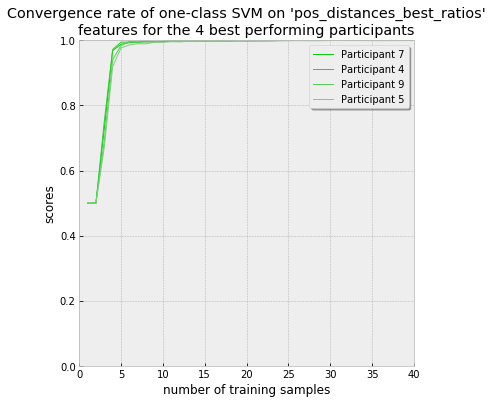

In [39]:
plotErrorToSampleCounts(samples, df_AUC_scores_best_4_OCSVM, feature_set_name, 
                        clf_name_OCSVM, samples[-1], 'best')

plotErrorToSampleCounts(samples, df_AUC_scores_best_4_OCSVM, feature_set_name, 
                        clf_name_OCSVM, samples[-1], 'best', 
                        saving_path=img_save_path)

##### Find for the four worst users (IF case):

In [40]:
df_AUC_scores_worst_4_IF = convergence_rate_many_users(X_selected_features, 
                                            worst_performing_user_ids_IF, 
                                            clf_IF, scaler, random_state, 
                                            samples, reps, 
                                            num_pos_test_convergence)

-- tracker: Working on training sample size of 40 (participant 4/4)


In [41]:
display(df_AUC_scores_worst_4_IF)

# drop the dataframe into a csv
df_AUC_scores_worst_4_IF.to_csv(logs_path + "worst 4 users AUC convergence scores of {} on '{}' features.csv"
                                                .format(clf_name_IF, feature_set_name), index=False)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
11,11,0.5,0.5,0.809021,0.720185,0.854701,0.863494,0.864486,0.867444,0.879997,0.888503,0.910669,0.909364,0.913639,0.917092,0.920569,0.931636,0.927758,0.928128,0.935917,0.934514,0.938908,0.933922,0.936167,0.940619,0.940869,0.942622,0.941625,0.943958,0.945517,0.946103,0.948911,0.952181,0.948764,0.947925,0.949761,0.949464,0.946856,0.948539,0.949286,0.946736
8,8,0.5,0.5,0.704664,0.788533,0.840421,0.868857,0.856183,0.874075,0.894556,0.886117,0.913797,0.920219,0.922614,0.917853,0.918244,0.916367,0.928303,0.933564,0.936417,0.935111,0.937889,0.938692,0.935692,0.943428,0.937192,0.934344,0.935725,0.939097,0.941089,0.945272,0.942989,0.944314,0.942592,0.940586,0.941958,0.943272,0.944172,0.942622,0.944172,0.944336
6,6,0.5,0.5,0.696071,0.653026,0.833004,0.867958,0.898272,0.894983,0.912114,0.921953,0.922608,0.909469,0.906136,0.919625,0.933944,0.937553,0.930094,0.936692,0.936231,0.942433,0.941892,0.939225,0.945314,0.945722,0.952947,0.952839,0.956611,0.9611,0.958083,0.95355,0.950097,0.950706,0.953022,0.956817,0.957611,0.958375,0.959022,0.966003,0.964417,0.965514
13,13,0.5,0.5,0.740283,0.600607,0.90936,0.925393,0.952236,0.948356,0.952256,0.952897,0.95115,0.952447,0.950258,0.955811,0.956861,0.950775,0.958519,0.956486,0.953694,0.947669,0.949617,0.956553,0.954025,0.954844,0.948703,0.946353,0.946047,0.954669,0.955858,0.954356,0.94925,0.955314,0.955,0.956139,0.953731,0.95615,0.951856,0.954428,0.954464,0.956831


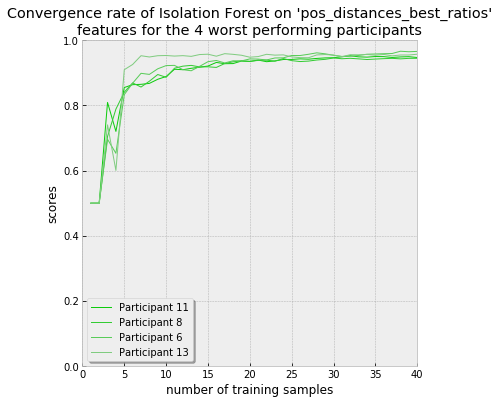

In [42]:
plotErrorToSampleCounts(samples, df_AUC_scores_worst_4_IF, feature_set_name, 
                        clf_name_IF, samples[-1], 'worst')

plotErrorToSampleCounts(samples, df_AUC_scores_worst_4_IF, feature_set_name, 
                        clf_name_IF, samples[-1], 'worst', 
                        saving_path=img_save_path)

##### Find for the four best users (IF case):

In [43]:
df_AUC_scores_best_4_IF = convergence_rate_many_users(X_selected_features, 
                                            best_performing_user_ids_IF, 
                                            clf_IF, scaler, random_state, 
                                            samples, reps, 
                                            num_pos_test_convergence)

-- tracker: Working on training sample size of 40 (participant 4/4)


In [44]:
display(df_AUC_scores_best_4_IF)

# drop the dataframe into a csv
df_AUC_scores_best_4_IF.to_csv(logs_path + "best 4 users AUC convergence scores of {} on '{}' features.csv"
                                                .format(clf_name_IF, feature_set_name), index=False)

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
9,9,0.5,0.5,0.824001,0.752015,0.924961,0.943442,0.948733,0.959197,0.967067,0.974125,0.984444,0.987419,0.988039,0.988403,0.988214,0.989389,0.988778,0.990567,0.989978,0.991081,0.991903,0.992931,0.993089,0.992622,0.993619,0.993214,0.993656,0.993581,0.994289,0.994633,0.994869,0.994947,0.995994,0.996025,0.995992,0.995556,0.995519,0.996122,0.996111,0.996539
4,4,0.5,0.5,0.860719,0.62076,0.9332,0.962696,0.968,0.982936,0.986778,0.987892,0.990969,0.990192,0.990192,0.989064,0.990936,0.992342,0.991878,0.992331,0.993767,0.994092,0.993392,0.993319,0.993711,0.993622,0.993025,0.992833,0.993914,0.993942,0.993947,0.994364,0.994389,0.993847,0.994778,0.9944,0.994592,0.994164,0.994683,0.994878,0.995222,0.9951
5,5,0.5,0.5,0.801475,0.769761,0.938444,0.941856,0.945511,0.955919,0.963158,0.969511,0.977508,0.979461,0.984967,0.980394,0.98405,0.984006,0.988575,0.988967,0.98925,0.988586,0.988822,0.9894,0.988075,0.989306,0.991675,0.991928,0.992692,0.991883,0.992458,0.993367,0.993819,0.993992,0.994222,0.993903,0.993306,0.993414,0.993478,0.993733,0.993742,0.993994
16,16,0.5,0.5,0.870726,0.804576,0.96275,0.962217,0.975186,0.9779,0.987253,0.989575,0.993486,0.992461,0.992689,0.989647,0.993294,0.993722,0.994686,0.994114,0.994756,0.994772,0.995064,0.994869,0.993419,0.994394,0.994939,0.994633,0.995142,0.994872,0.995286,0.995186,0.995728,0.996761,0.996858,0.996911,0.996653,0.996156,0.996567,0.996608,0.996903,0.996778


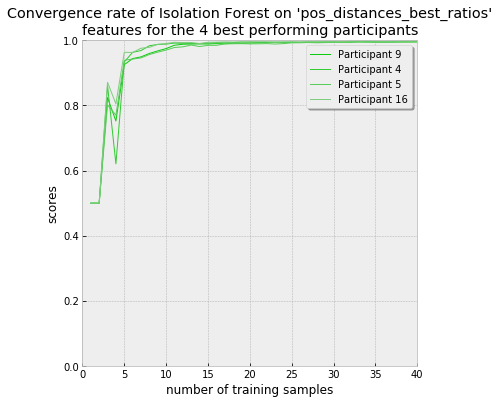

In [45]:
plotErrorToSampleCounts(samples, df_AUC_scores_best_4_IF, feature_set_name, 
                        clf_name_IF, samples[-1], 'best')

plotErrorToSampleCounts(samples, df_AUC_scores_best_4_IF, feature_set_name, 
                        clf_name_IF, samples[-1], 'best', 
                        saving_path=img_save_path)